In [1]:
from IPython.display import Image
from IPython.display import HTML
HTML(open('stylesheet.css').read())

# Team Quantimize
## Overview of this notebook:
### Setup:
- Project structure
- Installation
### Usage:
- Data preparation
- Visualization
- Classic solutions
- Quantum solutions
- Air security
- Benchmarks
- Results and discussion

This notebook shall run without any errors or problems and should demonstrate the result of our work, as well as a comparision and a possible quantum advantage. If there are errors, we kindly ask to try to run it again.

## Setup
### Project structure
The project is structured the following way:
Quantimize.ipynb is the main entry point. Every file has a brief explanation of what it contains and what it does.
- quantimize/:
    - benchmarking/:
        - benchmarking.py: for benchmarking our work
        - toolbox.py: for additional requirements to benchmarking
    - classic/:
        - classic_solution.py: for the genetic algorithm (GA)
        - toolbox.py:for the straight line solution and various needed methods for the GA
    - data/:
        - aCCF_0623_p_spec.nc: the original atmospheric data file
        - atmo.json: the new created atmospheric data file
        - bada_data.csv: file containing information about the flight level/TAS/ROC/ROD and fuel consumption
        - bada_data.json: file containing the same information but in a different format
        - flights.csv: file containing information about all the flights (start, stop, FL)
        - flights.json: file containing the same information but in a different format
    - output/:
        - Flight trajectories for flights 0 to 99 without 41. Every flight has its own *.csv file with the upper part being the solution to the genetic algorithm and the lower part being the solution to the quantum genetic algorithm. Upper and lower part are seperated by a blank line
    - quantum/:
        - QGA.py: as the quantum genetic algorithm
        - quantum_solution.py: containing the QAOA algorithm
        - quantum_neural_network.py: containing the quantum neural network
        - toolbox.py: containing additional functions
    - air_security.py: for air security related checks
    - classic_summary.py: for calls to classic functions
    - converter.py: for conversion of units (kts->km/h, minutes->seconds)
    - create_json_data.py: to explain how we generated our datafiles
    - data_access.py: gives access to all the converted data and returns them
    - quantum_summary.py: for calls to quantum functions
    - visualisation.py: for all visualisation related functions
### Installation
Our code requires the latest Python (3.10) and a virtual environment to decouple it from other environments or installations. Please install python from here [Python](https://www.python.org/). Make sure, that Python is listed in your PATH environment and then proceed creating a virtual environment. Open a command line and type
```commandline
python -m venv quantimize
quantimize\Scripts\activate.bat
```
to create a quantimize environment and to activate the environment.
The package can be cloned from github using 
```commandline
git clone https://github.com/fjelljenta/Quantum-Challenge
cd Quantum-Challenge
```
After that, one needs to install all required packages using
```commandline
pip install -r requirements.txt
```
Now, everything should be ready and set up to further run this notebook. Type
```commandline
jupyter notebook
```
and open the Quantimize.ipynb.

## Usage
This section is dedicated to show how the notebook can be used and to show our work and results.
### Data preparation
<div class='Exp'>
The data preparation is all related to the file "create_json_data.py". It can be used as a standalone application to convert all three given files (atmospheric data, flight data, flight list) into the corresponding \*.json files. This was done to get a better handle over the files and to adapt the access to our purposes. For example, some flight levels were converted from hPa to FL for simpler calculations and visualisations. Requirement for the file to run, is that there has to be a folder "data" (like in this project) in the current working directory. Also the files need to have the specific names for successful conversion. Further explanaition can be found in the file itself. We now want to concentrate more on the work we did.

### Notebook preparation
Important imports to make this notebook work as expected

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

### Visualisation
Visualisation is done for a better understanding of the data and of course for nice pictures to look at. To use the visualisation, we first have to import the visualisation part of the package. Also the datetime package, because we need to work with time objects.

In [3]:
from quantimize import visualisation as vs
from datetime import time as t

We can now access all functions in it. As an example, we want to plot the atmospheric data of a certain flightlevel and time and see how it looks like. We choose FL = 295 and a time of 8 o'clock in the morning.

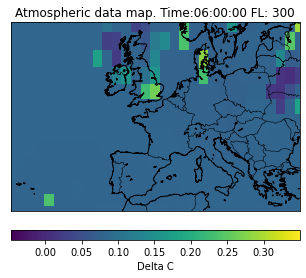

In [4]:
vs.make_atmo_map(295, t(8,0,0))

You will get the atmospheric data plotted in different colors, corresponding to the value and normalized to the min and max value available. In the title, you can also see, that there were some assumptions:
1. We have no atmospheric data for FL 295, so we choose the closest, which is FL 300
2. We also do not have atmospheric data for 8 o'clock in the morning. Therefore, we refer to 6 o'clock in the morning.

Regarding the time, we split the time in intervals from 6 to 9 corresponding to the data of 6 o'clock, 9 to 15 corresponding to the data of 12 o'clock and 15 to 21 corresponding to the data of 18 o'clock.

We also can animate the atmospheric data either for a fixed time variing in the FL or vice verca with a fixed FL variing in time. These function do not work in this notebook, because they are repetitive. We included a video of them below, so you can see what it will actually show. The color scheme is equivalent to the one before. Blue/purple being low values or negativ ones, while yellow represents high values.

`vs.make_animated_atmo_FL_map(t(12))`

In [5]:
HTML("""
    <video alt="Atmospheric data for all flight levels at 12 o'clock" controls>
        <source src="quantimize/notebook_visual/atmo_day_map_for_12_00.mp4" type="video/mp4">
    </video>
""")

`vs.make_animated_atmo_day_map(295)`

In [6]:
HTML("""
    <video alt="Atmospheric data for all flight levels at 12 o'clock" controls>
        <source src="quantimize/notebook_visual/atmo_day_map_for_FL295.mp4" type="video/mp4">
    </video>
""")

Further visualisation will be presented, when showing flight paths.
### Classic solutions
In our work, we provide two different classic solutions. One being the simplest, the straight line solution, and the other being the genetic algorithm (GA).
#### Straight line solution
The straight line solution, as the name suggests, just computes a straight line from start to end, without any variation. The function takes the flight number (17) and a timestep dt, here 300 seconds, as input.

In [7]:
flight_nr = 17
dt = 300

In [8]:
import quantimize.classic_summary as classic_solution
trajectory_sls = classic_solution.straight_line_solution(flight_nr, dt)

The trajectory can now be plotted as a 2D graph for example. First we create a map and then plot the flight path.

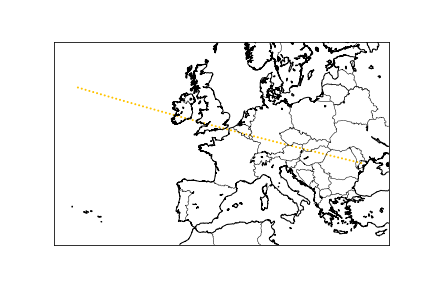

In [9]:
%matplotlib widget
map = vs.make_map()
vs.scatter_flight_path_on_map(map, trajectory_sls)

In the graph, you can see a dotted line showing the flight path. The color of the dots refer to the flight level this time. Later this changes, by introducing the flight levels. Then the color represents the atmospheric data values. We can also now calculate the cost.

In [10]:
cost = classic_solution.compute_cost(trajectory_sls)
print(cost)

1793.3229766154702


The cost has the unit 10e-12 K.

#### Genetic algorithm solution
In the genetic algorithm solution (GA) we use the genetic algorithm to find boundary points and then calculate from these points the optimal flight trajectory. This function is adapted to give uniform time distance for later calculations.

In [11]:
trajectory_ga = classic_solution.genetic_algorithm_solution(flight_nr, dt)

The objective function also contains already the cost of this flight. We can now plot this again, this time in 3D to see the flight level changes first and then with atmospheric data.

(<Axes3DSubplot:>, <mpl_toolkits.basemap.Basemap at 0x275c8c41b70>)

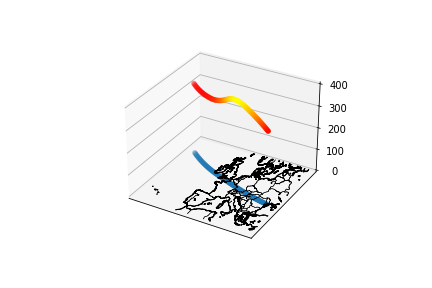

In [12]:
ax, map3d = vs.make_3d_map()
vs.scatter_flight_path_on_map_3d(ax,map3d,trajectory_ga)

The colors represent the value of the flight level to be consistent with the previous example. In the next plot we add the atmospheric data.

(<Axes3DSubplot:>, <mpl_toolkits.basemap.Basemap at 0x275c8c813f0>)

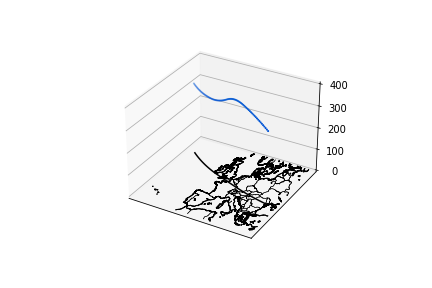

In [13]:
ax, map3d = vs.make_3d_map()
vs.plot_flight_path_on_map_3d_with_atmo_as_points(ax, map3d, trajectory_ga)

This plot shows the atmospheric data in terms of different colors for the flight points. In the next plot we want to see a bit more than the flight path but also the outer regions

(<Axes3DSubplot:>, <mpl_toolkits.basemap.Basemap at 0x275e36edba0>)

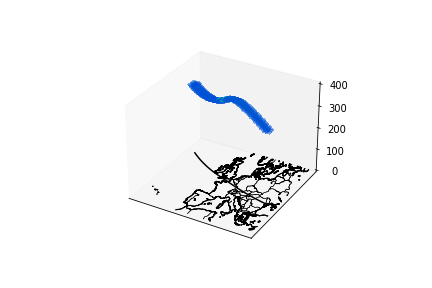

In [14]:
ax, map3d = vs.make_3d_map()
vs.plot_flight_path_on_map_3d_with_atmo_as_slices(ax, map3d, trajectory_ga)

The colors represent the value of the atmospheric data in squares around the flight path point. You can gain inside into the atmospheric data next to the flight path. The corners of the squares are the points which values are visualized. Therefore one can see, how the algorithm tries to avoid 'expensive' regions. On the ground you can see the projection of the flight path for a better visualisation. With variation in the flight level, one can obtain already a much better result than just staying on the same flight level. We can also check the cost, but these should be similar to the objective function.

In [15]:
cost = classic_solution.compute_cost(trajectory_ga)
print(cost)

1261.556978181422


The small deviation comes from a different spacing of the points as mentioned above, but is in the same order as the original result.

### Quantum solution
Our quantum solutions consist of three different. The first is the quantum equivalent to the genetic algorithm. The second one ist a quantum neural network and the third one is a mapping of atmospheric data to a qubit grid.
#### Quantum genetic algortihm


In [16]:
import quantimize.quantum_summary as quantum_solution
trajectory_qga = quantum_solution.quantum_genetic_algorithm_solution(flight_nr, dt, print_bool=True)

Start QGA. Generation: 0
Running QGA. Generation: 2
Running QGA. Generation: 4
Running QGA. Generation: 6
Running QGA. Generation: 8
Running QGA. Generation: 10
Running QGA. Generation: 12
Running QGA. Generation: 14
Running QGA. Generation: 16
Running QGA. Generation: 18
Running QGA. Generation: 20
Running QGA. Generation: 22
Running QGA. Generation: 24
Running QGA. Generation: 26
Running QGA. Generation: 28
Running QGA. Generation: 30
Running QGA. Generation: 32
Running QGA. Generation: 34
Running QGA. Generation: 36
Running QGA. Generation: 38
Running QGA. Generation: 40
Running QGA. Generation: 42
Running QGA. Generation: 44
Running QGA. Generation: 46
Running QGA. Generation: 48
Finished QGA. Generation: 49


We can again plot this trajectory and compute its cost

(<Axes3DSubplot:>, <mpl_toolkits.basemap.Basemap at 0x275eb4ab8e0>)

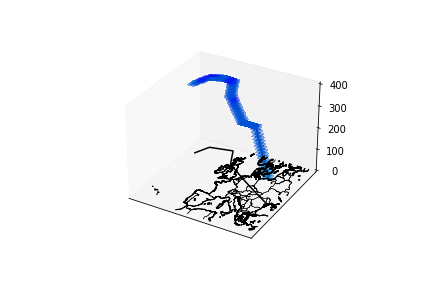

In [17]:
ax, map3d = vs.make_3d_map()
vs.plot_flight_path_on_map_3d_with_atmo_as_slices(ax, map3d, trajectory_qga)

In [18]:
cost = classic_solution.compute_cost(trajectory_qga)
print(cost)

1149.6036507172225


As one can see, the algorithm gives an output, which is not as smooth as the classic solution. The climate efficiency is slightly better than for the classic GA (might/will depend on the chosen flight). But the flight trajectory is not as smooth as the one compared to the GA.


#### Quantum neural network (QNN)
The quantum neural network (QNN) base function needs already precalculated boundary points and tries to optimize those further. In this high level call, we first let the algorithm calculate the boundary points and then pass them to the QNN for optimization. The boundary points result from the classic GA algorithm.

In [19]:
optimized_ctrl_pts = quantum_solution.quantum_neural_network(flight_nr, 6)

Calculated boundary points
Iteration = 2, Number of device executions = 2, Cost = 1685.8481178513496
Iteration = 4, Number of device executions = 5, Cost = 1484.1864305622273
Iteration = 6, Number of device executions = 8, Cost = 1356.3758277406894
Iteration = 8, Number of device executions = 11, Cost = 1425.366596534806
Iteration = 10, Number of device executions = 14, Cost = 1671.2182694099533
Iteration = 12, Number of device executions = 17, Cost = 1595.0088335337316
Iteration = 14, Number of device executions = 20, Cost = 1427.0664892864459
Iteration = 16, Number of device executions = 23, Cost = 1351.6442977387023
Iteration = 18, Number of device executions = 26, Cost = 1484.1281896220394
Iteration = 20, Number of device executions = 29, Cost = 1441.266989715562
Iteration = 22, Number of device executions = 32, Cost = 1557.3615463921797
Iteration = 24, Number of device executions = 35, Cost = 1720.1662815859254
Iteration = 26, Number of device executions = 38, Cost = 1328.06034265

In [20]:
print(optimized_ctrl_pts)

     fun: 1334.9002099145298
 message: 'terminated after reaching max number of iterations'
    nfev: 100
     nit: 50
 success: True
       x: array([ 144.40639711,  -18.82388892,  121.07976105,  -38.7364376 ,
        -13.75680953, -116.48812573,  -24.395335  ,  150.22377662,
         89.84285446, -256.02625484,  179.6455562 ,   77.53155596,
        -49.58554402, -116.60513406, -440.1294533 ,  200.10736767,
        -65.90445755, -190.21665439,  131.14133063, -524.48555885,
       -512.71534279,   78.59438313, -189.88015201,   44.90986137,
         42.90653748,   73.65347837, -132.47943772,   95.49146761,
        -49.15787125,  572.76991856,  348.9886388 , -231.02253831,
       -229.87251959,  186.6391711 , -226.0996702 ,   28.97633624,
       -148.64256615,  154.01172311, -118.97871577,   78.84290587,
       -169.64044512,   35.37398335,  157.03147618,   26.61593228,
        144.37411296,   94.90608461, -128.3535351 ,  295.56217221,
        -85.03018975, -140.41410345,   29.70535284, 

The QNN is unfortunatly only able to compute the cost and not to produce a trajectory. The computed cost (might/will vary), is bigger than the cost of the GA algorithm. This is related to the nature of the QNN because it uses a quite different approach to the problem. Additionally, the QNN is also expensive in computation cost and would need definetly more than 6 qubits for better results.

#### QAOA for QUBO

This section will briefly show what code was implemented for our QAOA solution. For the theory, please read the corresponding section in the submitted paper.

In [21]:
gc = quantum_solution.sample_grid()

In [22]:
print('The cost grid is')
print(gc)

The cost grid is
[[-5 -5 -5 -5]
 [-5 -1 -5 -5]
 [-5 -1 -5 -5]
 [-5 -5 -5 -5]]


In [23]:
a,b,c = quantum_solution.run_QAOA(gc)

Cost function in Ising Hamiltonian form: -3.0*Z11*Z12 - 1.0*Z11*Z21 - 6.0*Z11 - 5.0*Z12*Z22 - 3.0*Z21*Z22 + 10.0*Z22
Cost function in QUBO form: -12.0*q11*q12 - 4.0*q11*q21 - 4.0*q11 - 20.0*q12*q22 + 16.0*q12 - 12.0*q21*q22 + 8.0*q21 + 36.0*q22 - 16.0


In [24]:
print('By QAOA, the center qubits are of the states', b)
print('The resultant grid is')
print(c)

By QAOA, the center qubits are of the states [0 1 1 1]
The resultant grid is
[[ 1.  1.  1.  0.]
 [ 1.  1. -1. -1.]
 [ 1. -1. -1. -1.]
 [ 0. -1. -1. -1.]]


### Air security
Air security is essential for all planes in the air to avoid crashes and to save lives. After a flight trajectory is calculated, one has to check that the route has no steeper turns than 25°, that the plane is at least 10 FL above and below of other planes or has a distance of 5 nm (9,26 km) to the next plane. This can be checked with our air safety functions and will now be shown.

Since our code relys on timestamps, we first want do do an estimation of how close we have to choose our timesteps:

s = 9.26km

vmax = 459kts = 850 km/h

t = s/vmax = 39,2 s

After some calculations, we decided to reduce this time to 15 s. In that way we reduce the space available for other flights to cross without being detected. One could of course also use a different value, but 15 seconds fit good in a general scale of time(minutes) and provides us with enough points to detect possible collisions. We now calculate all available trajectories and check them for the air safety requirements:

In [25]:
import quantimize.air_security as air_safety

In [26]:
flights= [i for i in range(100)]
flights.remove(41)
trajectory_sls = []
for i in tqdm(flights):
    if i != 41:
        trajectory_sls.append(classic_solution.straight_line_solution(i, 15))

100%|█| 99/99 [00:57<00:00,  1


Now that every flight trajectory is calculated, we can do our air safety check.

In [27]:
safety_errors_sls = air_safety.check_safety(trajectory_sls, 15)
if len(safety_errors_sls)>0:
    print("Crashes found")
else:
    print("Everything alright")

Crashes found


In [28]:
print(safety_errors_sls)

[(datetime.time(12, 49, 45), (23.924479599082133, 59.94832814674327, 250.0, 18), (23.835671923811837, 59.975655099822, 250.0, 68)), (datetime.time(12, 50), (23.954131264132236, 59.968616128093345, 250.0, 18), (23.874711569876965, 59.981438751090906, 250.0, 68)), (datetime.time(12, 50, 15), (23.98378292918234, 59.98890410944342, 250.0, 18), (23.913751215942092, 59.98722240235981, 250.0, 68))]


This function call shows, that for all flights in a straight line, we only have collissions between two flights (18 and 68) for a time starting at 12:49:45 until 12:50:15. Since all flights are in a straight line, we don't need to check for too tight turns. Here is a visualisation of the two conflicting flights:

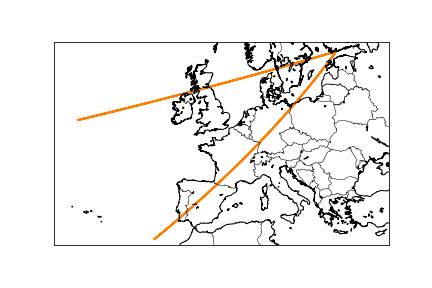

In [29]:
fig, ax = plt.subplots()
map = vs.make_map()
vs.scatter_flight_path_on_map(map, trajectory_sls[18])
vs.scatter_flight_path_on_map(map, trajectory_sls[68-1])

One can see, that they come very close at the end. Th 68-1 just works around the gap from the removed flight 41. 

We now concentrate on the GA and QGA trajectories. These need to be checked for tight turns.

In [30]:
flights= [i for i in range(100)]
flights.remove(41)

In [31]:
trajectories_ga, conflicts_ga = air_safety.safe_algorithm_2(flights, classic_solution.genetic_algorithm_solution)
print("number of trajectories: ", len(trajectories_ga))
print("remaining collisions:", conflicts_ga)

Finished trajectory calculation
Running check: 0
Current conflicts [20, 84, 73, 85, 3, 40, 42, 55, 22, 24, 61, 48, 82, 44, 69, 4, 62, 79]
Running check: 1
Current conflicts [84, 4, 55, 43, 24, 80, 20, 68, 79, 44, 69, 62, 85]
Running check: 2
Current conflicts [68, 20, 84, 44, 69, 18, 85]
Running check: 3
Current conflicts [84, 20, 82, 18, 79, 44, 69, 86]
Running check: 4
Current conflicts [44, 69, 43, 84, 59, 86]
Running check: 5
Current conflicts [43, 61]
Running check: 6
Current conflicts []
number of trajectories:  99
remaining collisions: []


To check if the algorithm did work, we briefly run all trajectories again through the radius check and safety check.

In [32]:
ga_safety = air_safety.check_safety(trajectories_ga, 15)
if len(ga_safety) == 0:
    print("No collision issues")
else:
    print("Collision issues with", ga_safety)
    
for trajectory in trajectories_ga:
    if not air_safety.radius_control(trajectory):
        print("Radius issues with", trajectory["flight_nr"])

No collision issues


We see, that our algorithm was able to almost solve every issue with our flights.

Now we repeat the same procedure for the QGA.

In [33]:
trajectories_qga, conflicts_qga = air_safety.safe_algorithm_2(flights, quantum_solution.quantum_genetic_algorithm_solution)
print("number of trajectories: ", len(trajectories_qga))
print("remaining collisions:", conflicts_qga)

Finished trajectory calculation
Running check: 0
Current conflicts [86, 66, 20, 61, 12, 45, 48, 36, 60, 19, 93, 52, 72, 84, 34, 69, 88]
Running check: 1
Current conflicts [66, 88]
Running check: 2
Current conflicts [66, 15, 88]
Running check: 3
Current conflicts [15, 88]
Running check: 4
Current conflicts [15, 88]
Running check: 5
Current conflicts [15, 12, 88]
Running check: 6
Current conflicts []
number of trajectories:  99
remaining collisions: []


In [34]:
qga_safety = air_safety.check_safety(trajectories_qga, 15)
if len(qga_safety) == 0:
    print("No collision issues")
else:
    print("Collision issues with", qga_safety)
    
for trajectory in trajectories_qga:
    if not air_safety.radius_control(trajectory):
        print("Radius issues with", trajectory["flight_nr"])

No collision issues
Radius issues with 1
Radius issues with 38


This section showed, how we can also fulfill all air safety requirements with our algorithms. Only minor errors occured especially regarding the radius issues. However, these should be easily resolvable in further steps.

## Benchmarks
Since one task of our challenge is to compare our algorithms, we now come to benchmarking. We have various variables we will benchmark in the following. This includes, flight time, fuel consumption, computation time and the environmental impact. In the first step, we create a list with all flights, except 41 and let every flight be calculated 10 times. In the end we will plot our results.

In [1]:
import quantimize.benchmarking.toolbox as bt
import quantimize.benchmarking.benchmarking as bb

In [2]:
flights= [i for i in range(100)]
flights.remove(41)
runs=5

In [3]:
Mean_comp_time, Error_comp_time, Mean_cost, Error_cost, Mean_flight_time, Error_flight_time, Mean_fuel, Error_fuel= bb.benchmark_wrapper(flights, runs)

Finished run  1  of trajectory calculation with  function straight_line_solution
Finished run  2  of trajectory calculation with  function straight_line_solution
Finished run  3  of trajectory calculation with  function straight_line_solution
Finished run  4  of trajectory calculation with  function straight_line_solution
Finished run  5  of trajectory calculation with  function straight_line_solution
Finished run  1  of trajectory calculation with  function genetic_algorithm_solution
Finished run  2  of trajectory calculation with  function genetic_algorithm_solution
Finished run  3  of trajectory calculation with  function genetic_algorithm_solution
Finished run  4  of trajectory calculation with  function genetic_algorithm_solution
Finished run  5  of trajectory calculation with  function genetic_algorithm_solution
Finished run  1  of trajectory calculation with  function quantum_genetic_algorithm_solution
Finished run  2  of trajectory calculation with  function quantum_genetic_alg

In [4]:
Mean_comp_time_as, Error_comp_time_as, Mean_cost_as, Error_cost_as, Mean_flight_time_as, Error_flight_time_as, Mean_fuel_as, Error_fuel_as = bb.benchmark_wrapper(flights, runs, Air_security=True)



Finished trajectory calculation
Running check: 0
Current conflicts [48, 91, 20, 84, 25, 95, 61, 73, 53, 96, 22, 87, 43, 44, 69, 18, 79]
Running check: 1
Current conflicts [44, 69, 92, 18, 68, 43, 85]
Running check: 2
Current conflicts [79, 44, 69, 18, 68]
Running check: 3
Current conflicts [18, 79]
Running check: 4
Current conflicts []
Finished run  1  of trajectory calculation with  function genetic_algorithm_solution


Finished trajectory calculation
Running check: 0
Current conflicts [18, 68, 84, 15, 88, 43, 59, 27, 20, 6, 36, 33, 34, 44, 69, 79]
Running check: 1
Current conflicts [44, 69, 6, 36, 18, 85, 15, 88]
Running check: 2
Current conflicts [6, 36, 15, 88]
Running check: 3
Current conflicts [15, 88]
Running check: 4
Current conflicts [15, 88]
Running check: 5
Current conflicts [15, 88]
Running check: 6
Current conflicts [15, 88]
Running check: 7
Current conflicts [15, 88]
Running check: 8
Current conflicts [15, 88]
Running check: 9
Current conflicts []
Finished run  2  of tr

### Benchmarking of computation time

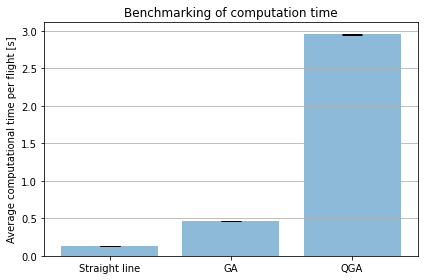

In [5]:
bt.plot_graph('Benchmarking of computation time','Average computational time per flight [s]', Mean_comp_time, Error_comp_time)

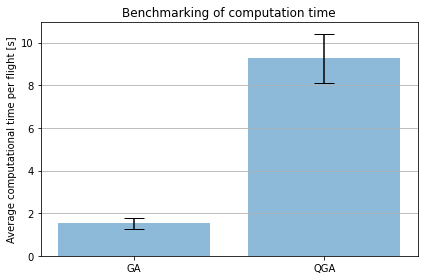

In [6]:
bt.plot_graph('Benchmarking of computation time','Average computational time per flight [s]', Mean_comp_time_as, Error_comp_time_as)

### Benchmarking of climate cost

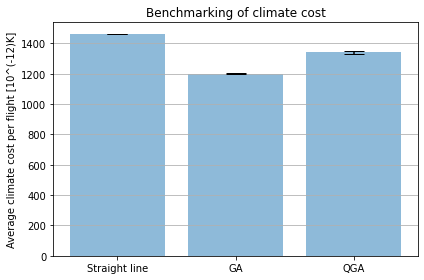

In [7]:
bt.plot_graph('Benchmarking of climate cost','Average climate cost per flight [10^(-12)K]', Mean_cost, Error_cost)

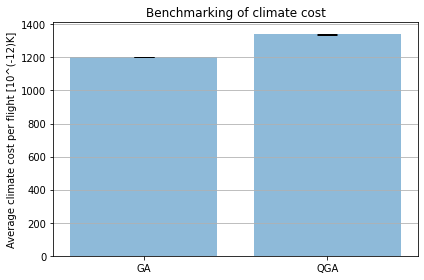

In [8]:
bt.plot_graph('Benchmarking of climate cost','Average climate cost per flight [10^(-12)K]', Mean_cost_as, Error_cost_as)

### Benchmarking of flight time

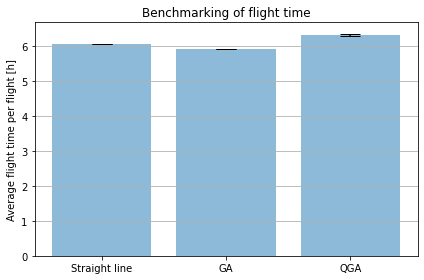

In [9]:
bt.plot_graph('Benchmarking of flight time','Average flight time per flight [h]', Mean_flight_time/3600, Error_flight_time/3600)

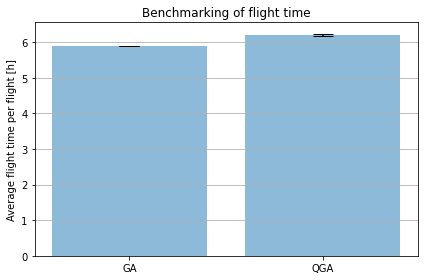

In [10]:
bt.plot_graph('Benchmarking of flight time','Average flight time per flight [h]', Mean_flight_time_as/3600, Error_flight_time_as/3600)

### Benchmarking of fuel consumption

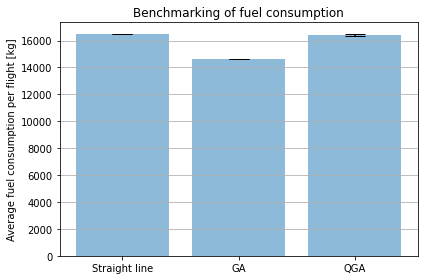

In [11]:
bt.plot_graph('Benchmarking of fuel consumption','Average fuel consumption per flight [kg]', Mean_fuel, Error_fuel)

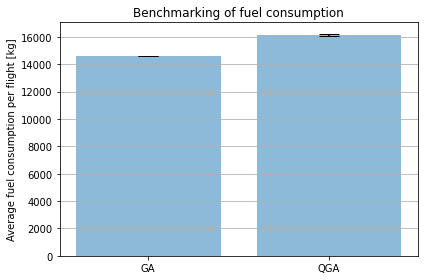

In [12]:
bt.plot_graph('Benchmarking of fuel consumption','Average fuel consumption per flight [kg]', Mean_fuel_as, Error_fuel_as)